Run this after example_meteoradar and example_scalar_sensor

In [8]:
import requests
import json
import numpy as np
import tiledb
import uuid

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

In [60]:
import abc

class TimeSeries(abc.ABC):

    def pre_fetch(self):
        args = {'after': self.after, 'before': self.before,
                'bucket': self.bucket, 'op': self.op}
        res = self.sensor.get_timeseries(args)
        self.timebase = res['timebase']
        self.timedelta = np.array(res['timedelta'])
        return res['data']

    @abc.abstractmethod
    def fetch(self):
        pass

    @abc.abstractmethod
    def get_item(self, args):
        pass

    def __getitem__(self, indx):
        return self.get_item(np.index_exp[indx])

    def __init__(self, sensor, after, before, bucket, op):
        self.sensor = sensor
        self.after = after
        self.before = before
        self.bucket = bucket
        self.op = op
        self.fetch()


class ScalarTimeSeries(TimeSeries):
    def fetch(self):
        data = self.pre_fetch()
        # FIXME multi channel sensors would be supported using
        # something like
        # self.data = dict((fname,
        #                   np.array(res['data'][fname]
        #                   for fname in res['data'])
        self.data = np.array(data)

    def get_item(self, args):
        assert len(args) == 1
        return (self.timedelta[args], self.data[args])


class NonScalarTimeSeries(TimeSeries):
    def fetch(self):
        self.data = self.pre_fetch()

    def fetch_data_block(self, args):
        if self.bucket is None:
            block_of_refs = self.data[args[0]]
            block_of_refs = block_of_refs \
                if isinstance(args[0], slice) else [block_of_refs]
            return self.sensor.fetch_data_block(
                block_of_refs, args)
        else:
            raise ValueError(f'bucket not supported')

    def get_item(self, args):
        assert len(args) > 0
        timedeltas = self.timedelta[args[0]]
        if isinstance(args[0], slice) and len(timedeltas) == 0:
            return (timedeltas, np.array([], dtype=np.int32))
        else:
            return (timedeltas, self.fetch_data_block(args))


In [61]:
class Sensor(abc.ABC):
    def __init__(self, client, sensor_type, description):
        self.client = client
        self.code = description['code']
        self.sensor_type = sensor_type
        self.desc = description

    def geometry(self):
        return self.desc['geometry']

    def get_timeseries(self, args):
        return self.client.get_timeseries(self.code, args)

    def fetch_data_block(self, block_of_refs, args):
        return self.client.fetch_data_block(block_of_refs, args)

    @abc.abstractmethod
    def timeseries(self, after, before, bucket=None, op=None):
        pass


class ScalarSensor(Sensor):
    def timeseries(self, after, before, bucket=None, op=None):
        return ScalarTimeSeries(self, after, before, bucket, op)


class NonScalarSensor(Sensor):
    def timeseries(self, after, before, bucket=None, op=None):
        return NonScalarTimeSeries(self, after, before, bucket, op)


In [71]:
sensor_classes = {
    'meteoRadar': NonScalarSensor,
    'temperatureSensorNetwork': NonScalarSensor
}

class Client:
    def __init__(self, tdmq_base_url, tiledb_ctx=None):
        self.base_url = tdmq_base_url
        self.tiledb_ctx = tiledb_ctx
        self.sensor_types = None
        self.update_sensor_types()

    def update_sensor_types(self):
        stypes = requests.get(f'{self.base_url}/sensor_types').json()
        self.sensor_types = dict((st['code'], st) for st in stypes)

    def make_sensor_proxy(self, sensors):
        return [sensor_classes[self.sensor_types[s['stypecode']]['type']](
                self, self.sensor_types[s['stypecode']], s) for s in sensors]

    def get_sensors(self, args):
        res = requests.get(f'{self.base_url}/sensors', params=args).json()
        return self.make_sensor_proxy(res)

    def get_timeseries(self, code, args):
        return requests.get(f'{self.base_url}/sensors/{code}/timeseries',
                            params=args).json()

    def fetch_data_block(self, block_of_refs, args):
        urls = set(r[0] for r in block_of_refs)
        # FIXME we support only the trivial case, for the time being
        assert len(urls) == 1
        indices = np.array([r[1] for r in block_of_refs], dtype=np.int32)
        assert len(indices) == 1 or np.all(indices[1:] - indices[:-1] == 1)
        url = urls.pop()
        if isinstance(args[0], slice):
            args = (slice(int(indices.min()),
                          int(indices.max()) + 1), ) + args[1:]
        else:
            assert len(indices) == 1
            args = (int(indices[0]),) + args[1:]
        with tiledb.DenseArray(url, mode='r', ctx=self.tiledb_ctx) as A:
            data = A.__getitem__(args)
        return data


In [72]:
# tdmq constants
TDMQ_BASE_URL = 'http://web:8000/api/v0.0'
TILEDB_HDFS_ROOT = 'hdfs://hdfs:9000/arrays'
TDMQ_NAMESPACE_UUID = uuid.UUID('367b5aee-8609-3c20-b130-4eb927a2d62b')
TILEDB_CTX = tiledb.Ctx({'vfs.hdfs.username': 'root'})

In [73]:
c = Client(TDMQ_BASE_URL, TILEDB_CTX)

In [103]:
args = {
    'footprint': 'circle((9.2215, 30.0015), 1000000)',
    'after': '2019-06-20T12:00:00Z',
    'before':'2019-06-20T21:50:25Z'
}
sensors = c.get_sensors(args)

In [105]:
sensors[1].sensor_type

{'brandName': 'DPC',
 'category': ['sensor'],
 'code': '0fd67c67-c9be-45c6-9719-4c4eada4bbbb',
 'controlledProperty': ['TEMP'],
 'function': ['sensing'],
 'manufacturerName': 'Dipartimento Protezione Civile',
 'modelName': 'dpc-temperature-mosaic',
 'name': 'Mosaic of dpc temperature sensors',
 'reference': 'http://www.protezionecivile.gov.it/attivita-rischi/meteo-idro/attivita/previsione-prevenzione/centro-funzionale-centrale-rischio-meteo-idrogeologico/monitoraggio-sorveglianza/mappa-radar',
 'type': 'temperatureSensorNetwork'}

In [108]:
args = {
    'after': '2019-06-20T12:00:00Z',
    'before':'2019-06-20T21:50:25Z'
}
ts = sensors[1].timeseries(**args)

In [109]:
(tdeltas, data) = ts[4]

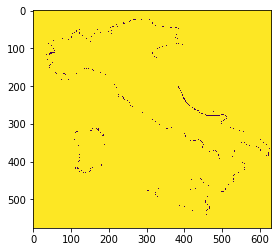

In [110]:
plt.imshow(data['TEMP'])

In [111]:
temp = data['TEMP'] * (data['TEMP'] > -9000.0)

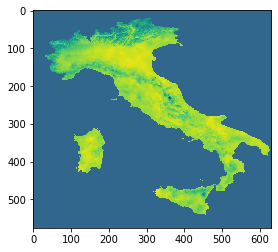

In [112]:
plt.imshow(temp)

In [133]:
(tdeltas, data) = ts[4, 300:440, 100:200]

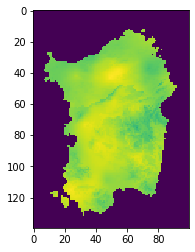

In [134]:
plt.imshow(data['TEMP'] * (data['TEMP'] > -9000.0))